In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from classifiers.quantum.qasvm import NormQSVM
from qiskit.circuit.library import ZZFeatureMap
from classifiers.quantum.ansatz import Circuit1
from qiskit.providers.aer import AerSimulator
from qiskit.utils import QuantumInstance
from qiskit import transpile

In [4]:
def my_function(m, n):
    data = np.random.random(size=(2**m, 2**n))
    label = np.where(np.random.random(2**m)>0, 1, 0)
    feature_map = ZZFeatureMap(feature_dimension=2**n)
    var_qc = Circuit1(m, 1, skip_final_rotation_layer=True)
    backend = AerSimulator()
    quantum_instance = QuantumInstance(backend=backend, shots=2**13)
    qasvm = NormQSVM(data, label, quantum_instance=quantum_instance, var_form=var_qc, feature_map=feature_map, lamda=1.0)
    return transpile(qasvm.second_order_circuit, backend=backend, basis_gates=['rx', 'ry', 'rz', 'cx'], optimization_level=0).depth()

In [5]:
from tqdm.notebook import tqdm
from itertools import product
m = np.arange(2, 9)
n = np.arange(2, 8)
X, Y = np.meshgrid(m, n)
Z = np.empty_like(X)
for i, j in tqdm(list(product(range(len(m)), range(len(n))))):
    Z[j, i] = np.log2(my_function(m[i], n[j]))

  0%|          | 0/42 [00:00<?, ?it/s]

Text(0.5, 0, 'log(depth)')

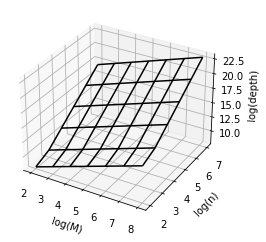

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='black')
ax.set_xlabel('log(M)')
ax.set_ylabel('log(n)')
ax.set_zlabel('log(depth)')

In [7]:
from sklearn.linear_model import LinearRegression
XY = np.asarray(list(zip(X.flatten(), Y.flatten())))
ZZ = Z.flatten()
reg = LinearRegression().fit(XY, ZZ, sample_weight=(X.flatten()+Y.flatten()))
print("d = O(2^{:.3f} * M^{:.3f} * n^{:.3f}), R^2={:.3f}".format(reg.intercept_, reg.coef_[0], reg.coef_[1], reg.score(XY, ZZ)))

d = O(2^1.706 * M^1.001 * n^1.878), R^2=0.994


<Figure size 432x288 with 0 Axes>

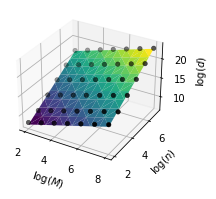

In [36]:
plt.tight_layout()
fig = plt.figure(figsize=(4, 3))
ax = plt.axes(projection='3d')
ax.scatter(X, Y, Z, color='black', linewidth=0.5)
ax.set_xlabel('$\log(M)$')
ax.set_ylabel('$\log(n)$')
ax.set_zlabel('$\log(d)$')
regx = np.linspace(min(X.flatten()), max(X.flatten()), 10)
regy = np.linspace(min(Y.flatten()), max(Y.flatten()), 10)
regX, regY = np.meshgrid(regx, regy)
regZ = reg.predict(list(zip(regX.flatten(), regY.flatten()))).reshape(regX.shape)
ax.plot_trisurf(regX.flatten(), regY.flatten(), regZ.flatten(), cmap='viridis', edgecolor='none')
fig.savefig('./figs/numerical_order_analysis.svg', dpi=300, facecolor='white', edgecolor='none')
fig.savefig('./figs/numerical_order_analysis.png', dpi=300, facecolor='white', edgecolor='none')